In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import pickle as pl


from barbar import Bar
from model import DAGMM
from forward_step import ComputeLoss
from utils.utils import weights_init_normal

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

import matplotlib.pyplot as plt

# 0. Data Load and Preprocessing
이 data는 군사 네트워크 환경에서 시뮬레이션을 통해 네트워크 트래픽을 얻고, 이것의 tcp dump data를 가공하여 만든 것으로 Denial of Service Attck, User to Root Attck, Remote to Lacal Attack, Probing Attack  이라는 총 4개의 attck을 포함하고 있습니다. 

이때, 'attack' data가 전체 data의 80%를 차지하기 때문에 이를 normal, 그렇지 않은 경우는 모두 abnormal로 판단합니다. 

In [17]:
class KDDCupData:
    def __init__(self, data_dir, mode):
        data = np.load(data_dir, allow_pickle=True)

        labels = data["kdd"][:,-1]
        features = data["kdd"][:,:-1]
        
        #attack인 feature가 normal
        normal_data = features[labels==0] 
        normal_labels = labels[labels==0]

        n_train = int(normal_data.shape[0]*0.5)
        ixs = np.arange(normal_data.shape[0])
        np.random.shuffle(ixs)
        normal_data_test = normal_data[ixs[n_train:]]
        normal_labels_test = normal_labels[ixs[n_train:]]

        if mode == 'train':
            self.x = normal_data[ixs[:n_train]]
            self.y = normal_labels[ixs[:n_train]]
        elif mode == 'test':
            anomalous_data = features[labels==1]
            anomalous_labels = labels[labels==1]
            self.x = np.concatenate((anomalous_data, normal_data_test), axis=0)
            self.y = np.concatenate((anomalous_labels, normal_labels_test), axis=0)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return np.float32(self.x[index]), np.float32(self.y[index])



def get_KDDCup99(args, data_dir='./data/kdd_cup.npz'):
    train = KDDCupData(data_dir, 'train')
    dataloader_train = DataLoader(train, batch_size=args.batch_size, 
                              shuffle=True, num_workers=0)
    
    test = KDDCupData(data_dir, 'test')
    dataloader_test = DataLoader(test, batch_size=args.batch_size, 
                              shuffle=False, num_workers=0)
    return dataloader_train, dataloader_test

# 1. Compression Network: Deep Autoencoder
compression network를 통해 먼저 축소된 차원에서의 reconstruction error를 구합니다. 
논문에 제시된 autoencoder의 구조는 다음과 같습니다. 

In [20]:
class DAGMM(nn.Module):
    def __init__(self, n_gmm=2, z_dim=1):
        """Network for DAGMM (KDDCup99)"""
        super(DAGMM, self).__init__()
        #Encoder network
        self.fc1 = nn.Linear(118, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 10)
        self.fc4 = nn.Linear(10, z_dim)

        #Decoder network
        self.fc5 = nn.Linear(z_dim, 10)
        self.fc6 = nn.Linear(10, 30)
        self.fc7 = nn.Linear(30, 60)
        self.fc8 = nn.Linear(60, 118)

        #Estimation network
        self.fc9 = nn.Linear(z_dim+2, 10)
        self.fc10 = nn.Linear(10, n_gmm)

    def encode(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        h = torch.tanh(self.fc3(h))
        return self.fc4(h)

    def decode(self, x):
        h = torch.tanh(self.fc5(x))
        h = torch.tanh(self.fc6(h))
        h = torch.tanh(self.fc7(h))
        return self.fc8(h)
    
    # activate function tanh 사용
    def estimate(self, z):
        h = F.dropout(torch.tanh(self.fc9(z)), 0.5)
        return F.softmax(self.fc10(h), dim=1)
    

    # reconstruction error는 relative euclidean distance, cosine similarity 등으로 구할 수 있음
    def compute_reconstruction(self, x, x_hat):
        relative_euclidean_distance = (x-x_hat).norm(2, dim=1) / x.norm(2, dim=1)
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return relative_euclidean_distance, cosine_similarity
    
    # forward의 경우 encoder를 거쳐 decoder로 복원하여 reconstruction error를 계산하고 이를 저장
    def forward(self, x):
        z_c = self.encode(x)
        x_hat = self.decode(z_c)
        rec_1, rec_2 = self.compute_reconstruction(x, x_hat)
        z = torch.cat([z_c, rec_1.unsqueeze(-1), rec_2.unsqueeze(-1)], dim=1)
        gamma = self.estimate(z)
        return z_c, x_hat, z, gamma

# 2. Estimation Network
이번에는 compression network에서 입력받은 $\mathbf{z}$를 통해 gaussian mixture model로 density estimation을 진행합니다.   
forword: 논문의 objective function 값을 구하는 과정입니다. $J(\theta_e, \theta_d, \theta_m)=\dfrac{1}{N}\sum^N_{i=1}L(\mathbf{x_i}, \mathbf{x_i}')+\dfrac{\lambda_1}{N}\sum^N_{i=1}E(\mathbf{z_i})+\lambda_2P(\hat{\Sigma})$     
compute energy: $E(\mathbf{z})=-log({\sum^N_{i=1}\hat{\phi}_k\dfrac{exp(-\dfrac{1}{2}(\mathbf{z}-\hat{\mu}_k)^T\hat{\Sigma}^{-1}(\mathbf{z}-\hat{mu}_k))}{\sqrt{\lvert{2\pi\hat{\Sigma}_k}}\rvert}})$  
compute params(phi, mu, cov): $\hat{\phi}_k=\sum^N_{i=1}\dfrac{\hat{\gamma}_{ik}}{N}, \ \hat{\mu}_k=\dfrac{\sum^N_{i=1}\hat{\gamma}_{ik}\mathbf{z_i}}{\sum^N_{i=1}\hat{\gamma}_{ik}},\ \hat{\Sigma}_k=\dfrac{\sum^N_{i=1}\hat{\gamma}_{ik}(\mathbf{z_i}-\hat{\mu}_k)(\mathbf{z_i}-\hat{\mu}_k)^T}{\sum^N_{i=1}\hat{\gamma}_{ik}}$

In [24]:
class ComputeLoss:
    def __init__(self, model, lambda_energy, lambda_cov, device, n_gmm):
        self.model = model
        self.lambda_energy = lambda_energy
        self.lambda_cov = lambda_cov
        self.device = device
        self.n_gmm = n_gmm
    
    def forward(self, x, x_hat, z, gamma):
        """DAGMM의 loss 계산"""
        reconst_loss = torch.mean((x-x_hat).pow(2))

        sample_energy, cov_diag = self.compute_energy(z, gamma)

        loss = reconst_loss + self.lambda_energy * sample_energy + self.lambda_cov * cov_diag
        return Variable(loss, requires_grad=True)
    
    def compute_energy(self, z, gamma, phi=None, mu=None, cov=None, sample_mean=True):
        """Computing the sample energy function"""
        if (phi is None) or (mu is None) or (cov is None):
            phi, mu, cov = self.compute_params(z, gamma)

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        eps = 1e-12
        cov_inverse = []
        det_cov = []
        cov_diag = 0
        for k in range(self.n_gmm):
            cov_k = cov[k] + (torch.eye(cov[k].size(-1))*eps).to(self.device)
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag += torch.sum(1 / cov_k.diag())
        
        cov_inverse = torch.cat(cov_inverse, dim=0)
        det_cov = torch.cat(det_cov).to(self.device)

        E_z = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        E_z = torch.exp(E_z)
        E_z = -torch.log(torch.sum(phi.unsqueeze(0)*E_z / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + eps)
        if sample_mean==True:
            E_z = torch.mean(E_z)            
        return E_z, cov_diag

    def compute_params(self, z, gamma):
        """Computing the parameters phi, mu and gamma for sample energy function """ 
        # K: number of Gaussian mixture components
        # N: Number of samples
        # D: Latent dimension
        # z = NxD
        # gamma = NxK

        #phi = D
        phi = torch.sum(gamma, dim=0)/gamma.size(0) 

        #mu = KxD
        mu = torch.sum(z.unsqueeze(1) * gamma.unsqueeze(-1), dim=0)
        mu /= torch.sum(gamma, dim=0).unsqueeze(-1)

        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))
        z_mu_z_mu_t = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        
        #cov = K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_z_mu_t, dim=0)
        cov /= torch.sum(gamma, dim=0).unsqueeze(-1).unsqueeze(-1)

        return phi, mu, cov
        

# 공분산 행렬에 대해 cholesky 분해
class Cholesky(torch.autograd.Function):
    def forward(ctx, a):
        l = torch.cholesky(a, False)
        ctx.save_for_backward(l)
        return l
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

# 4. Training
training은 일반적인 autoencoder와 다르게 pre-train하지 않고 end-to-end로 학습합니다. 

In [ ]:
class TrainerDAGMM:
    """Trainer class for DAGMM."""
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader, self.test_loader = data
        self.device = device


    def train(self):
        """Training the DAGMM model"""
        self.model = DAGMM(self.args.n_gmm, self.args.latent_dim).to(self.device)
        self.model.apply(weights_init_normal)
        optimizer = optim.Adam(self.model.parameters(), lr=self.args.lr)

        self.compute = ComputeLoss(self.model, self.args.lambda_energy, self.args.lambda_cov, 
                                   self.device, self.args.n_gmm)
        self.model.train()
        for epoch in range(self.args.num_epochs):
            total_loss = 0
            for x, _ in Bar(self.train_loader):
                x = x.float().to(self.device)
                optimizer.zero_grad()
                
                _, x_hat, z, gamma = self.model(x)

                loss = self.compute.forward(x, x_hat, z, gamma)
                loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
                optimizer.step()

                total_loss += loss.item()
            print('[Train] Epoch: {}, Loss: {:.3f}'.format(epoch, total_loss/len(self.train_loader))

# 5. Test
test단에서는 training에서 학습한 parameter들을 기반으로 compress network와 estimation network를 거쳐 각 sample의 energy를 계산합니다.  
이를 바탕으로 특정 기준보다 큰 energy를 가지는 sample을 anomaly로 정의합니다. 

In [43]:
def eval(model, dataloaders, device, n_gmm):
    """Testing the DAGMM model"""
    dataloader_train, dataloader_test = dataloaders
    model.eval()
    print('[Test]')
    compute = ComputeLoss(model, None, None, device, n_gmm)
    with torch.no_grad():
        N_samples = 0
        gamma_sum = 0
        mu_sum = 0
        cov_sum = 0
        # Obtaining the parameters gamma, mu and cov using the trainin (clean) data.
        for x, _ in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            phi_batch, mu_batch, cov_batch = compute.compute_params(z, gamma)

            batch_gamma_sum = torch.sum(gamma, dim=0)
            gamma_sum += batch_gamma_sum
            mu_sum += mu_batch * batch_gamma_sum.unsqueeze(-1)
            cov_sum += cov_batch * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)
            
            N_samples += x.size(0)
            
        train_phi = gamma_sum / N_samples
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

        # Obtaining Labels and energy scores for train data
        energy_train = []
        labels_train = []
        for x, y in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, phi=train_phi,
                                                              mu=train_mu, cov=train_cov, 
                                                              sample_mean=False)
            
            energy_train.append(sample_energy.detach().cpu())
            labels_train.append(y)
        energy_train = torch.cat(energy_train).numpy()
        labels_train = torch.cat(labels_train).numpy()

        # Obtaining Labels and energy scores for test data
        energy_test = []
        labels_test = []
        for x, y in dataloader_test:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, train_phi,
                                                              train_mu, train_cov,
                                                              sample_mean=False)
            
            energy_test.append(sample_energy.detach().cpu())
            labels_test.append(y)
        energy_test = torch.cat(energy_test).numpy()
        labels_test = torch.cat(labels_test).numpy()
    
        scores_total = np.concatenate((energy_train, energy_test), axis=0)
        labels_total = np.concatenate((labels_train, labels_test), axis=0)

    # total score의 하위 80%를 normal, 상위 20%를 abnormal로 판단 
    threshold = np.percentile(scores_total, 100 - 20)
    pred = (energy_test > threshold).astype(int)
    gt = labels_test.astype(int)

    precision, recall, f_score, _ = prf(gt, pred, average='binary')
    print("Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(precision, recall, f_score))
    print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels_total, scores_total)*100))
    return labels_total, scores_total

## Training

In [42]:
class Args:
    num_epochs=50
    patience=50
    lr=1e-4
    lr_milestones=[50]
    batch_size=1024
    latent_dim=1
    n_gmm=4
    lambda_energy=0.1
    lambda_cov=0.005
    
    
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_KDDCup99(args)

dagmm = TrainerDAGMM(args, data, device)
dagmm.train()

198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 0, Loss: 20103702.479
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 1, Loss: 20076247.206
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 2, Loss: 20164327.247
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 3, Loss: 20097333.392
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 4, Loss: 20079630.644
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 5, Loss: 20121239.134
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 6, Loss: 20105944.902
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 7, Loss: 20085134.222
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 8, Loss: 20131693.201
198371/198371: [============

## Test

In [46]:
labels, scores = eval(dagmm.model, data, device, args.n_gmm)

[Test]
Precision : 0.9693, Recall : 0.9550, F-score : 0.9621
ROC AUC score: 99.49


test 결과, precosion, recall, F1-score 모두 논문에서 제시한 값보다 높았습니다. F1-score는 96%를 상회하고, AUROC는 99.5에 가까운 것으로 보아 DAGMM이 high-dimensional data의 anomaly detection에 있어 매우 좋은 성능을 보이고 있다고 말할 수 있습니다. 

다음은 gaussian mixture model의 density estimation 결과, normal과 abnormal이 확률 밀도에서 확연한 차이를 보이는지 확인해보도록 하겠습니다. 

In [56]:
scores_in = scores[np.where(labels==0)[0]]
scores_out = scores[np.where(labels==1)[0]]
in_ = pd.DataFrame(scores_in, columns=['Normal'])
out_ = pd.DataFrame(scores_out, columns=['Abnormal'])

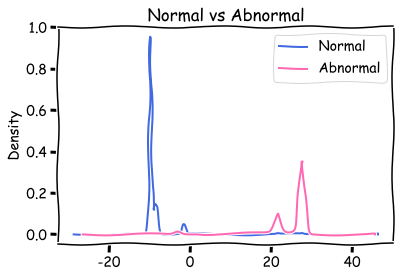

In [57]:
fig, ax = plt.subplots()
plt.xkcd()
in_.plot.kde(ax=ax, legend=True, title='Normal vs Abnormal', color='royalblue')
out_.plot.kde(ax=ax, legend=True, color='hotpink')
ax.grid(axis='x')
ax.grid(axis='y')
plt.show()

normal과 abnormal의 확률 밀도 분포가 확연하게 차이남을 확인할 수 있었습니다. 따라서 높은 performance score를 신뢰할 수 있고 DAGMM이 anomaly detection에 좋은 성능을 냄을 다시 한번 확인할 수 있었습니다. 다만, abnormal data가 noraml data에 비해 현저히 적은 현실의 data와 달리 이번 포스트에서 실험을 진행한 KDDcup99 data는 abnormal의 비율이 전체의 20%를 차지했기 때문에 anomaly가 매우 적은 data에서도 잘 작동하는지의 확인이 필요할 것 같습니다.